In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import platform
import os
import multiprocessing
import datetime

%matplotlib inline

In [2]:
# consts
# number of iterations:
config = open("tester_config", "r")
times = int(config.readline()[6:-1])

In [3]:
data = pd.read_csv("test_result.txt", sep=' ', header=None, names=["lib", 'test', 'test_name'] + [i for i in range(times)])

In [4]:
values = [i for i in range(times)]
data["mean"] = data[values].mean(axis=1)
data["std"]  = data[values].std(axis=1)
data["testid"] = data["test"] + "_" + data["test_name"]
data = data.reindex_axis(sorted(data.columns), axis=1)
tests = sorted(list(set(data['testid'].tolist())))
libs = sorted(list(set(data['lib'].tolist())))

# Tester results.
### Current system:

In [5]:
print "Version:", platform.platform()
print "CPU cores:", multiprocessing.cpu_count()
print "Page size:", os.sysconf('SC_PAGE_SIZE')
print "Current time:", datetime.datetime.now()

Version: Darwin-14.5.0-x86_64-i386-64bit
CPU cores: 8
Page size: 4096
Current time: 2016-05-05 00:49:02.233569


## Rankings
** Test passage points**:
* **10 points** for being in std of the best test performer **or**
* **5 - 10 points** for passing the test according to time,
* **-5** for failed test,
* **-2** for timeout.

**BONUS**: 
* **2** for best std in each test,
* **-3** for _std = 100 * best std_ in this test,
* **5** for all tests passage.

## Legend
* **Green** - passed successfully,
* **Yellow** - timeout,
* **Red** - failed.

In [6]:
p_group_best = 10
p_group_worst = 5

p_timeout = -2
p_fail = -5

p_best_std = 1
p_bad_std_mul = 100
p_bad_std = -3 
p_all_passed = 5

In [7]:
ranks = pd.DataFrame(index=libs, columns=tests).fillna(p_fail)
ranks['All test passed'] = np.zeros(len(libs))

datarank = data[['lib', 'testid', 'mean', 'std']]
for test in tests:
    testf = datarank[datarank.testid == test]
    best_mean = testf['mean'][testf['mean'] != -1].min()
    worst_mean = testf['mean'][testf['mean'] != -1].max()
    best_mean_std = testf[testf['mean'] == best_mean]["std"].values
    worst_mean_std = testf[testf['mean'] == worst_mean]["std"].values
    
    if len(best_mean_std) == 0:
        # All libs failed test:
        continue
    else:
        best_mean_std = best_mean_std[0]
        worst_mean_std = worst_mean_std[0]
        
    angle = (p_group_best - p_group_worst) / (best_mean - worst_mean)
        
    best_std = testf['std'][testf['std'] != 0].min()
    
    for index, row in testf.iterrows():
        if row["mean"] != -1:     
            if (np.abs(row["mean"] - best_mean) <= np.abs(row['std'] + best_mean_std)):
                ranks.set_value(row['lib'], row['testid'], p_group_best)
            else: 
                ranks.set_value(row['lib'], row['testid'], p_group_best - int((best_mean - row['mean']) * angle))
        else:
            ranks.set_value(row['lib'], row['testid'], p_timeout)
            
        # best std:
        if row["std"] == best_std:
            ranks.loc[row['lib'], row['testid']] += p_best_std
            
        # bad std:
        if row["std"] > p_bad_std_mul * best_std:
            ranks.loc[row['lib'], row['testid']] += p_bad_std
            
all_passed = ranks[ranks < 0].any(axis=1)

for i, item in all_passed.iteritems():
    if item == False: 
        ranks.set_value(i, 'All test passed', p_all_passed)

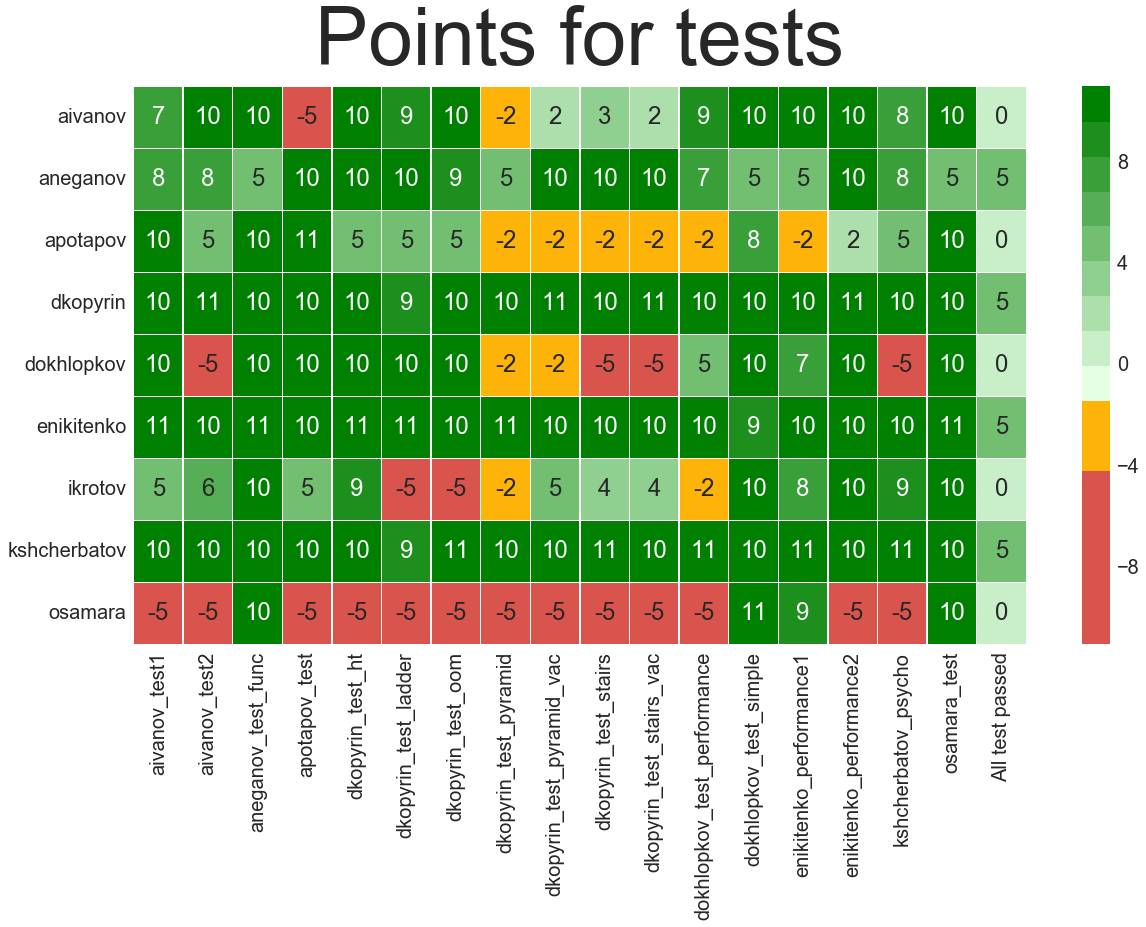

In [8]:
colors = ["pale red", "pale red", "pale red", "pale red", "pale red", "amber", "amber"]
cmap = matplotlib.colors.ListedColormap(sns.xkcd_palette(colors) + sns.light_palette("green", n_colors=9))

sns.set(font_scale=2)
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
sns.plt.title("Points for tests", fontsize=80, y=1.03)
sns.heatmap(ranks, annot=True, cmap=cmap, center=0, linewidths=.5)
plt.show()

In [9]:
# ## Code to shift "Test passage" plot to left
# from IPython.display import HTML
# HTML("""<script>
#   $(document).ready(function(){
#     $('div.prompt').hide();
#     $('nav#menubar').hide();
#   });
# </script>
# """)

In [10]:
ranks["sum"] = ranks.sum(axis=1)

ranks.sort_values(by=['sum'], ascending=False, inplace=True)

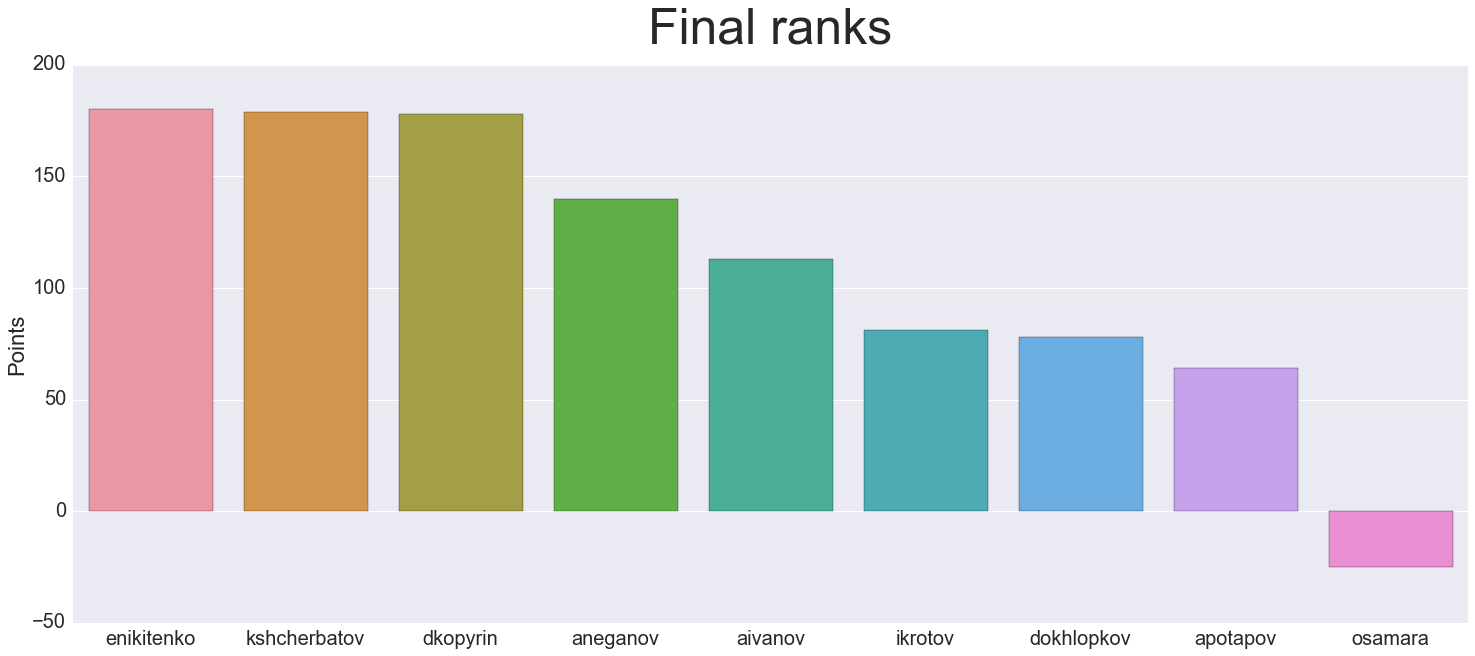

In [11]:
plt.figure(figsize=(25, 10))
sns.set(font_scale=2)
sns.plt.title("Final ranks", fontsize=50, y=1.03)
sns.barplot(y=ranks["sum"], x=ranks.index)
plt.ylabel('Points')
plt.show()

## Results by each test.
There are only libs that passed the test.

In [12]:
# data without timeout values.
passed_data = data[data["mean"] != -1]

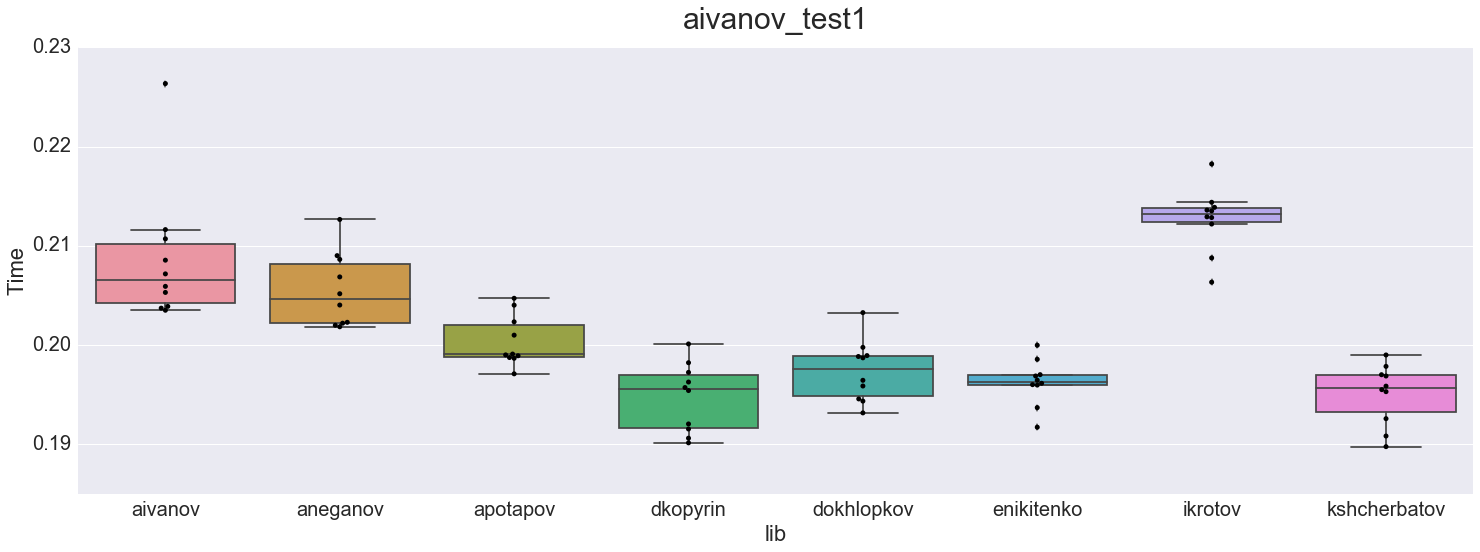

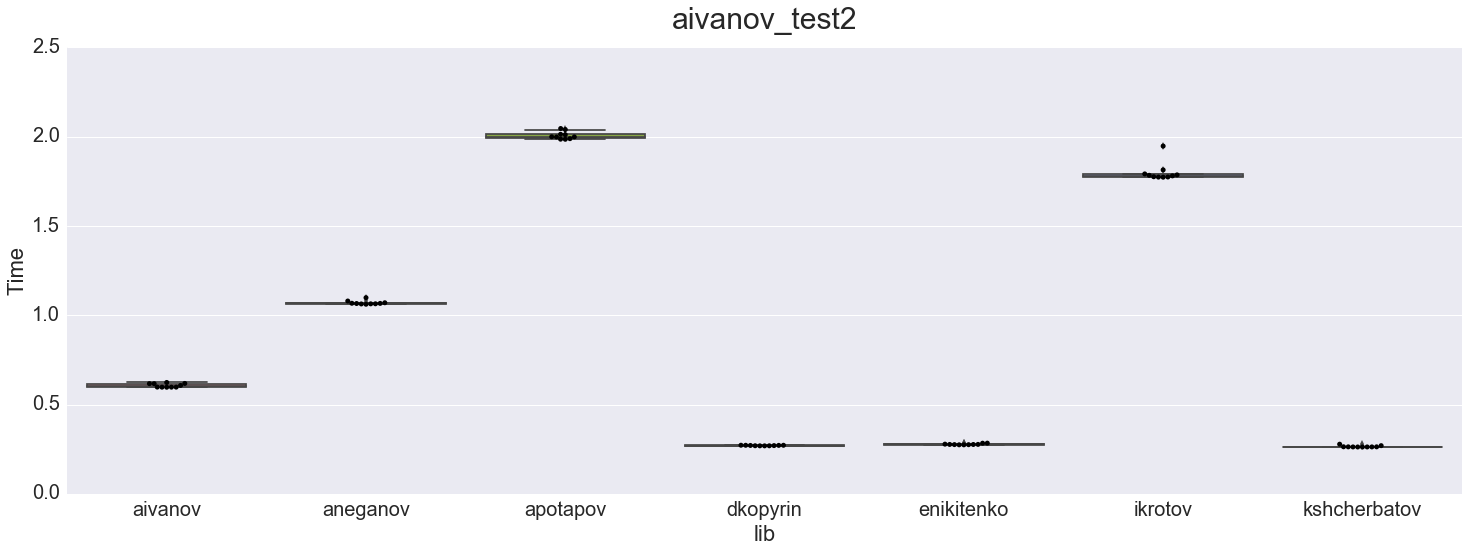

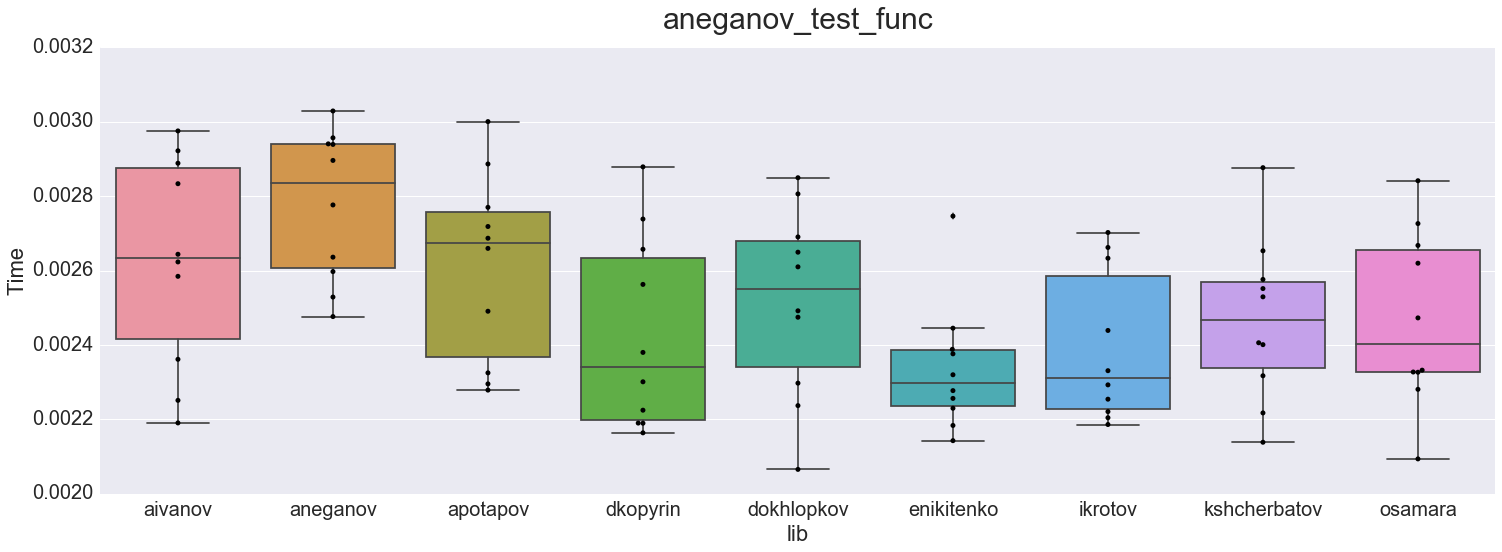

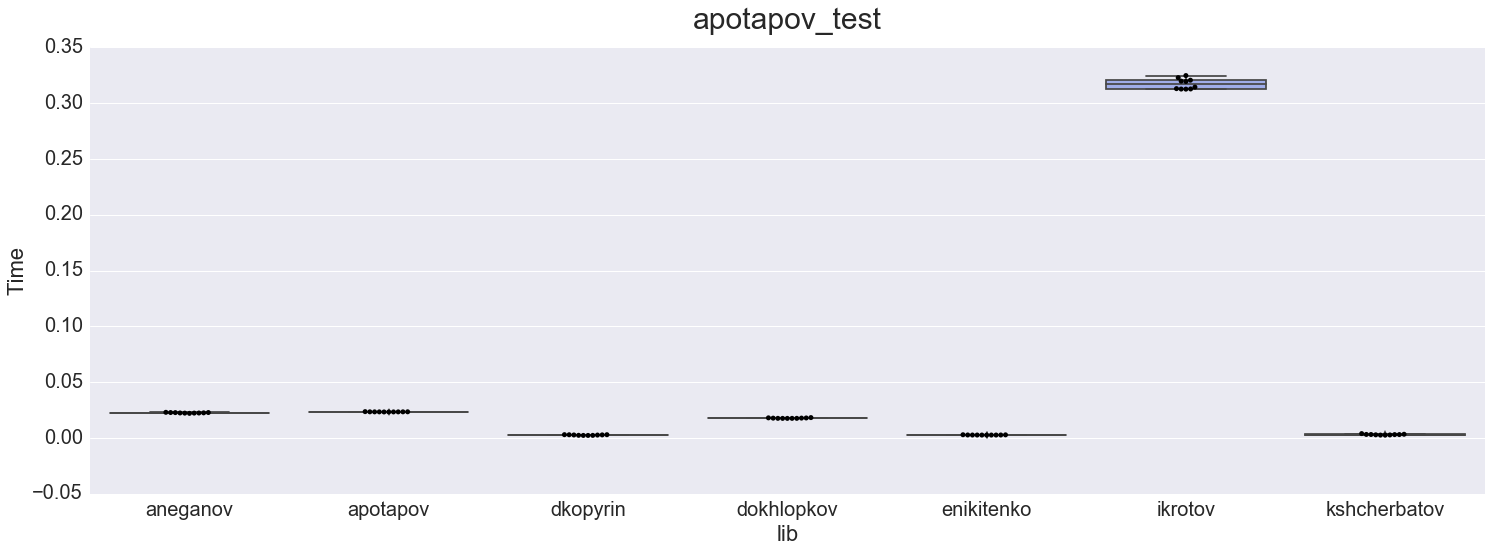

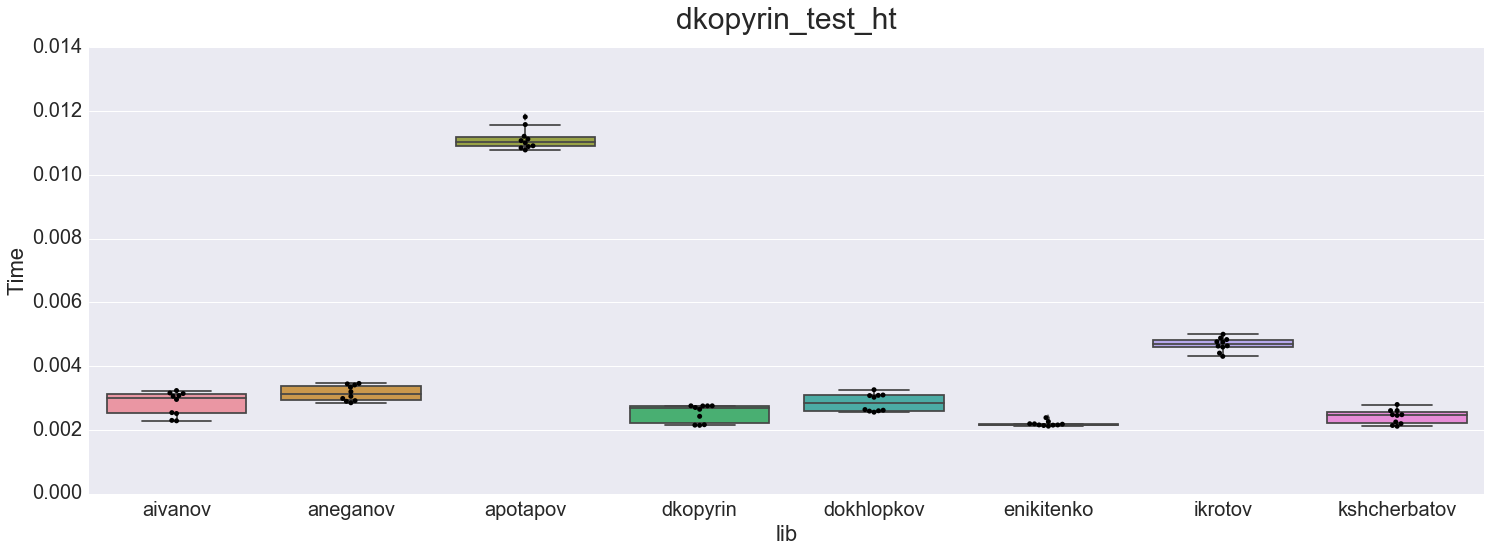

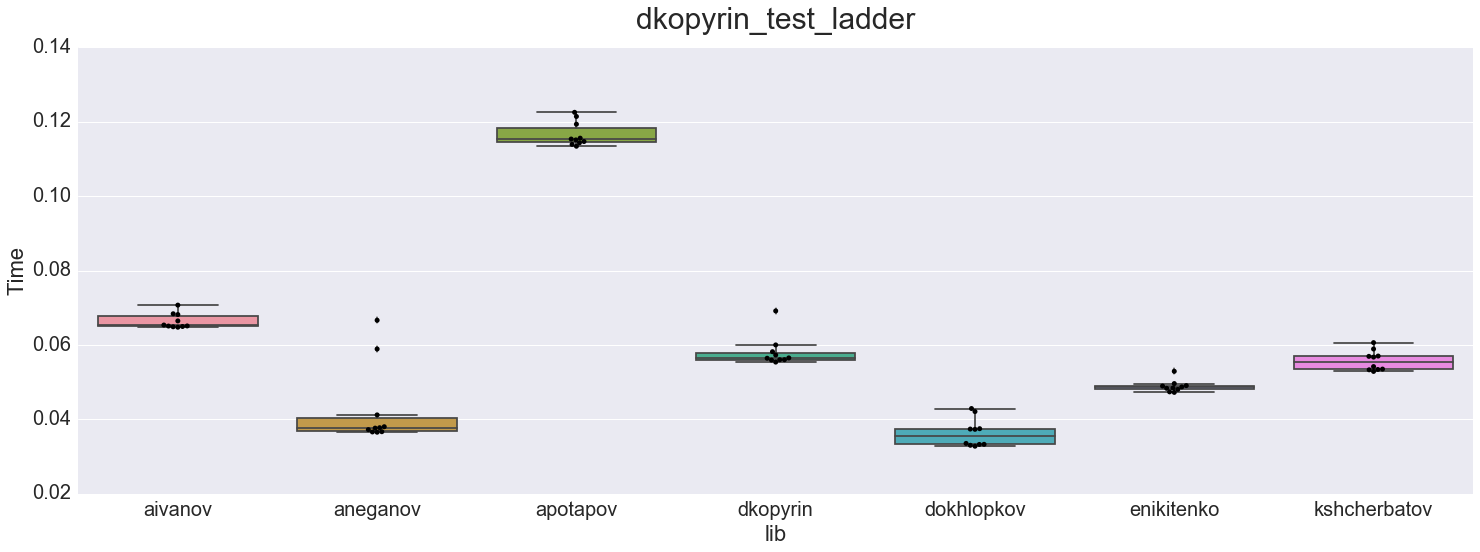

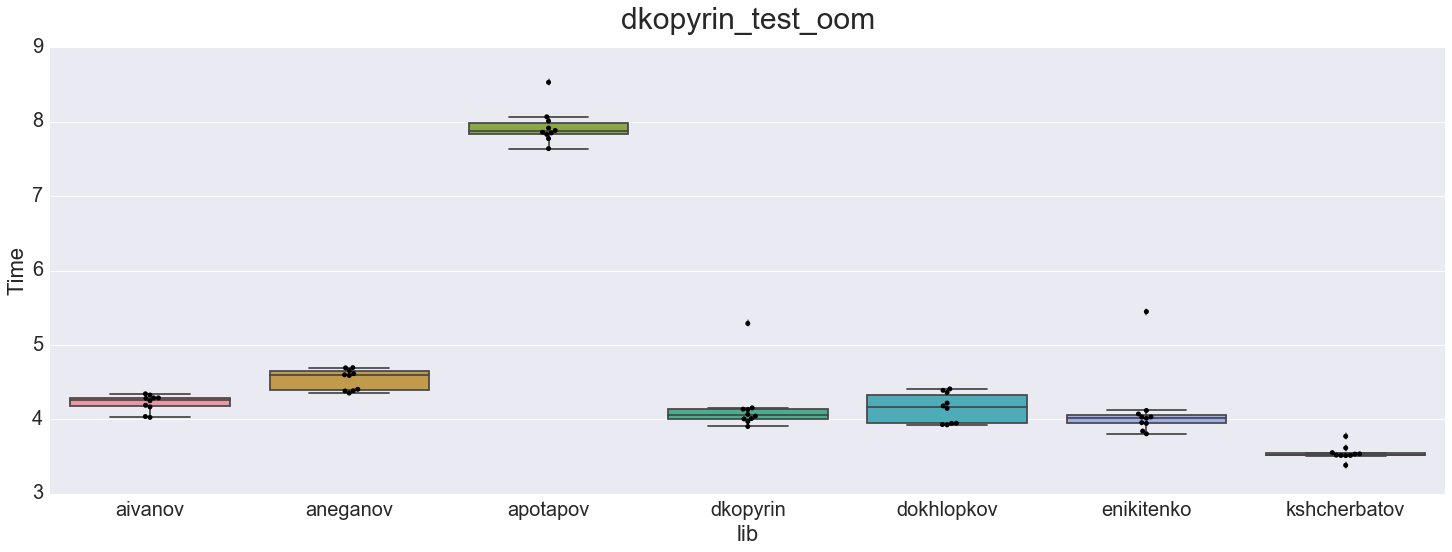

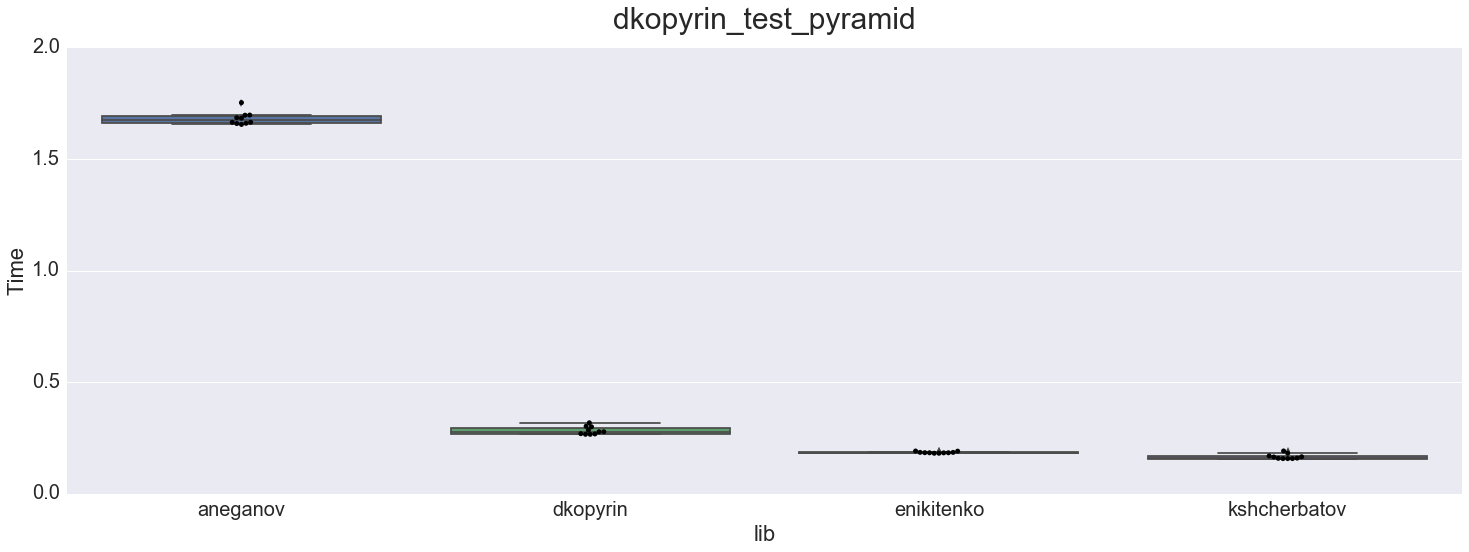

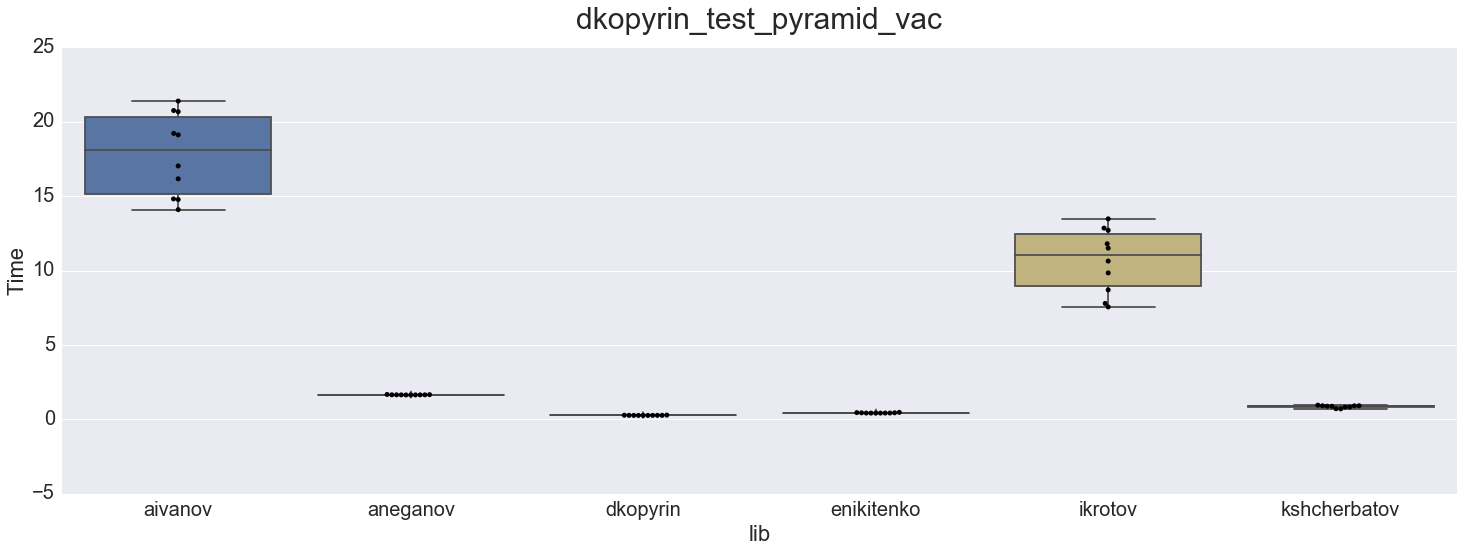

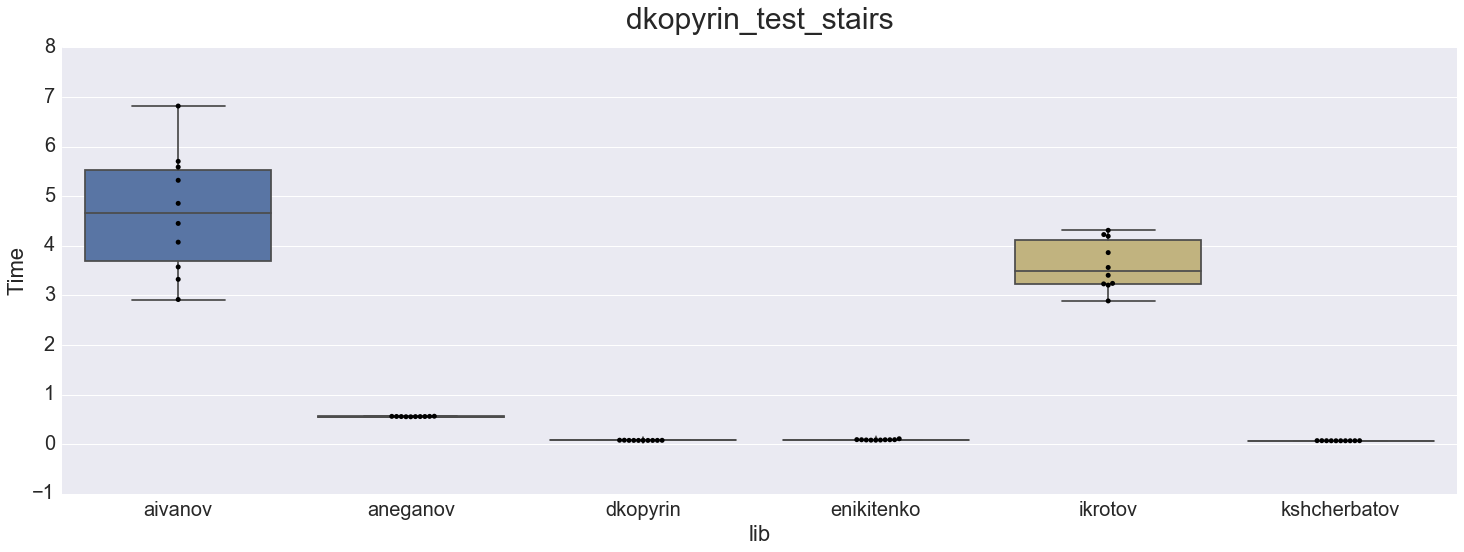

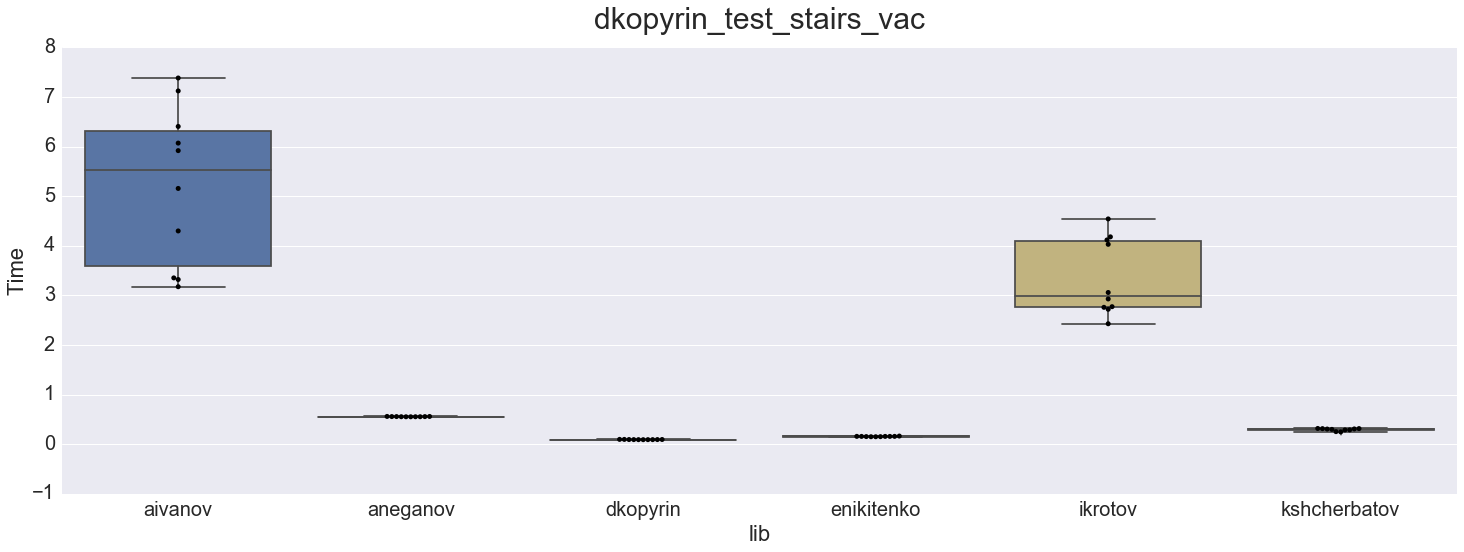

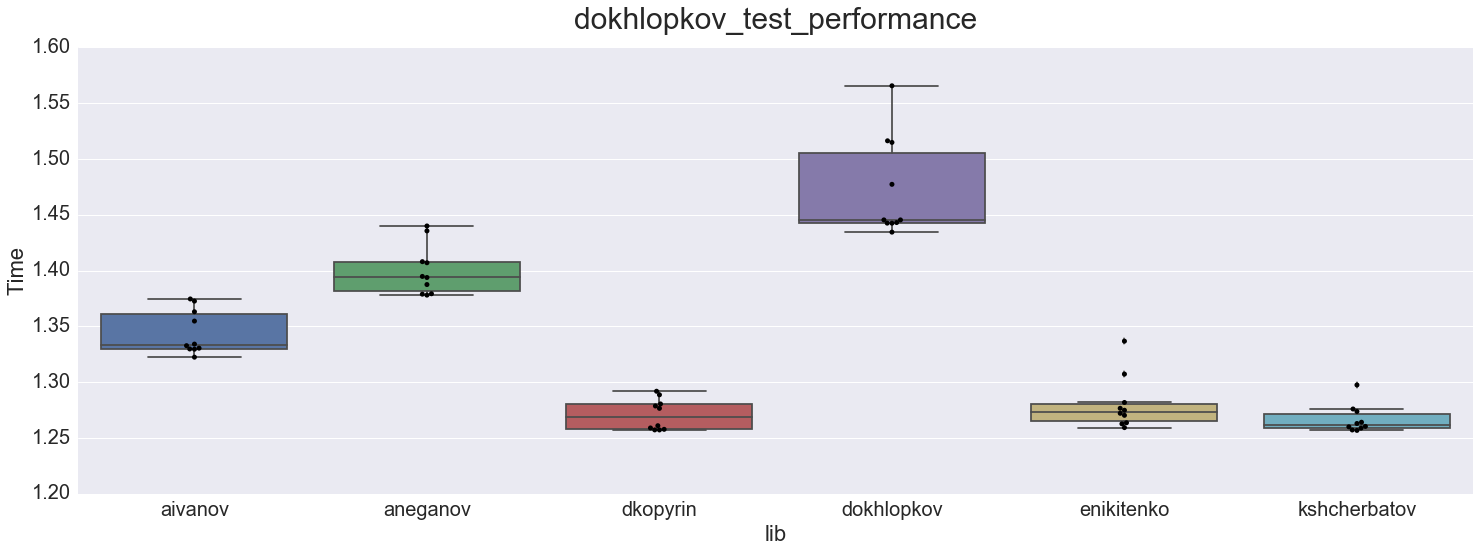

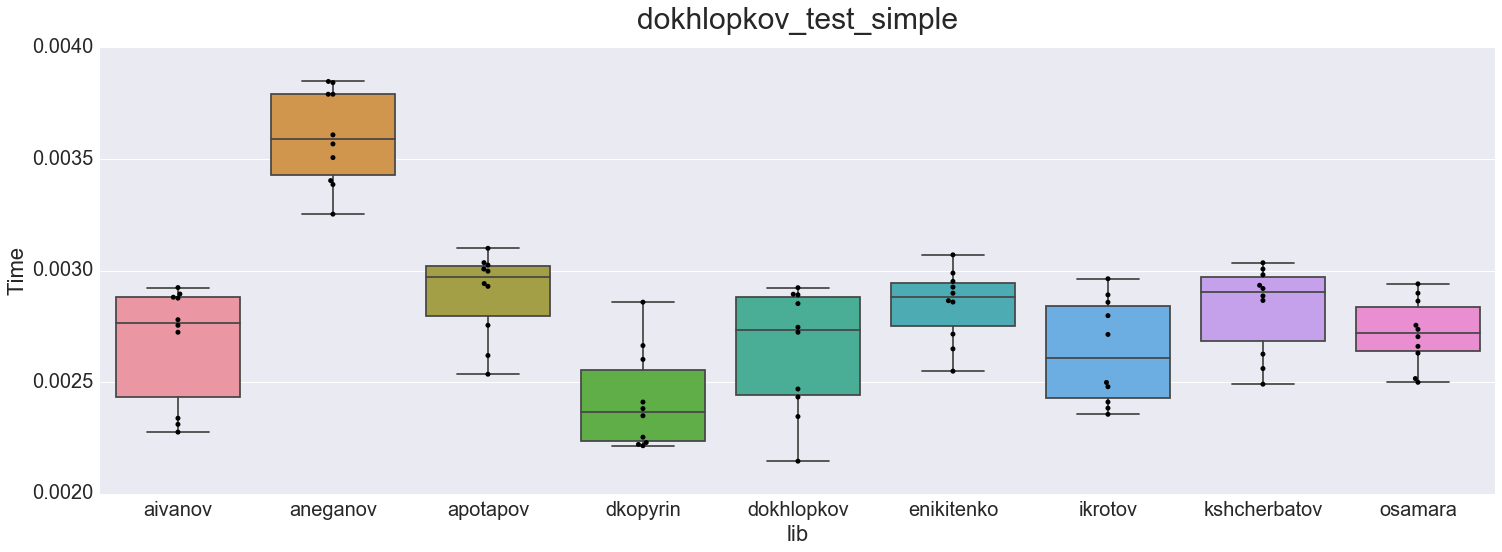

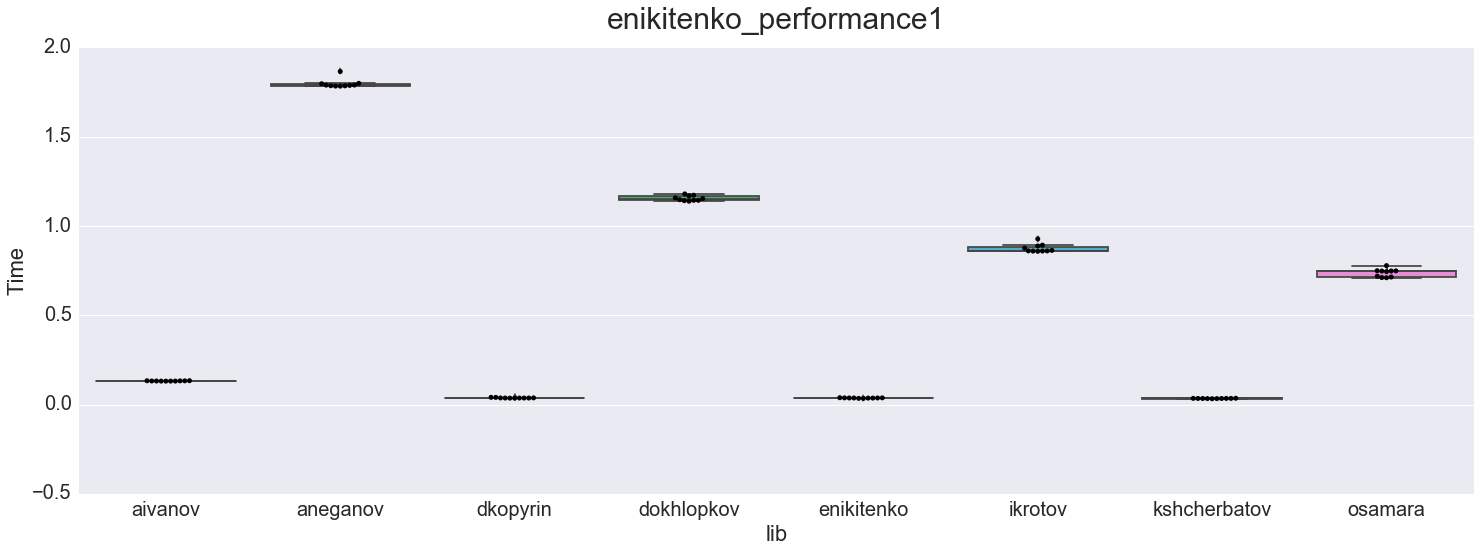

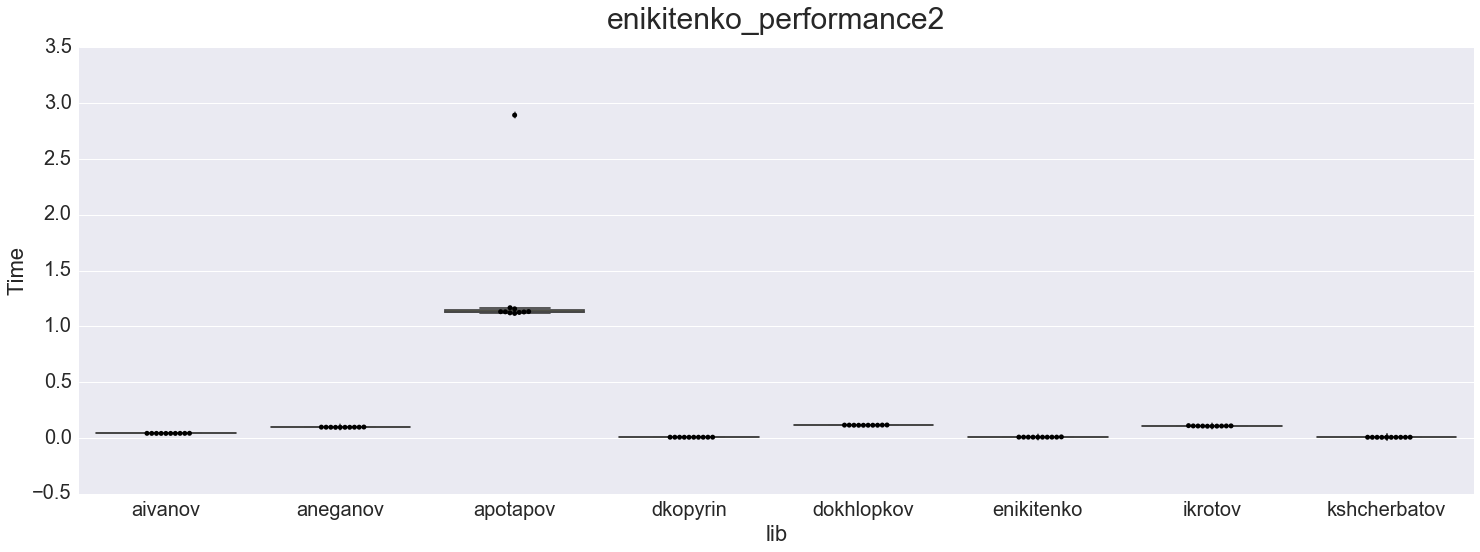

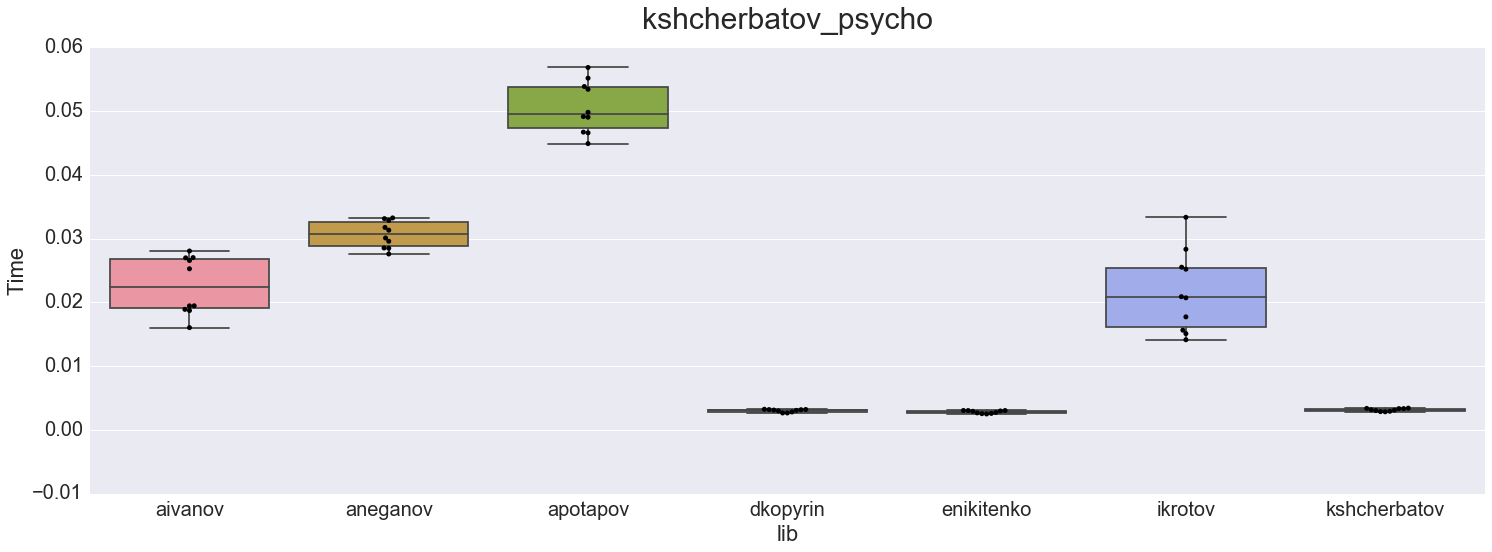

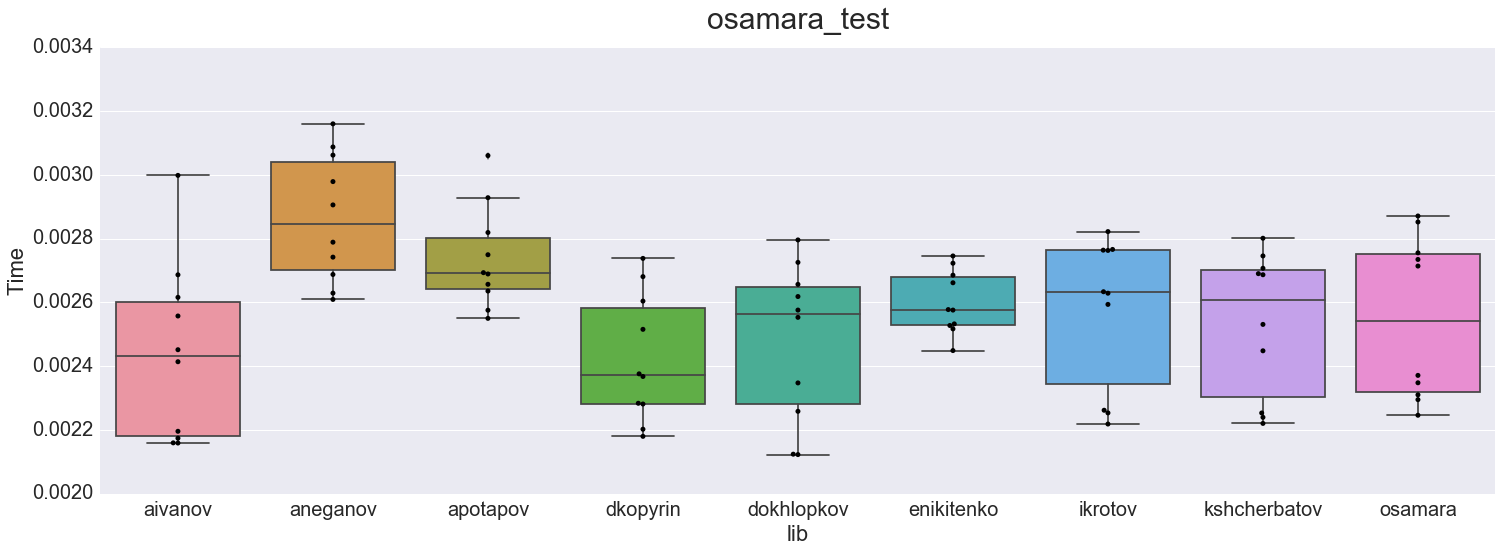

In [13]:
val = passed_data.set_index(passed_data["testid"]).drop(["test", "test_name", "mean", "std", 'testid'], axis=1)
sns.set(font_scale=2)
for test in tests:
    a = val[val.index == test]
    a = a.set_index(a['lib']).drop(["lib"], axis=1).transpose()
    if len(a.columns) == 0:
        print "\nAll libs have failed test %s.\n" % (test)
        continue
    plt.figure(figsize=(25, 8))
    sns.plt.title(test, fontsize=30, y=1.03)
    ax = sns.boxplot(data=a)
    sns.swarmplot(data=a, size=5, ax=ax, color="black")
    plt.ylabel('Time')
    plt.show()

## Raw results 
with mean and std

In [14]:
pd.set_option('display.max_rows', len(data))
data.drop(values, axis=1)

,lib,mean,std,test,test_name,testid
0,aivanov,0.208673,0.006840,aivanov,test1,aivanov_test1
1,aivanov,0.606849,0.010862,aivanov,test2,aivanov_test2
2,aivanov,0.002627,0.000284,aneganov,test_func,aneganov_test_func
3,aivanov,0.002830,0.000374,dkopyrin,test_ht,dkopyrin_test_ht
4,aivanov,0.066401,0.002032,dkopyrin,test_ladder,dkopyrin_test_ladder
5,aivanov,4.220697,0.113053,dkopyrin,test_oom,dkopyrin_test_oom
6,aivanov,-1.000000,0.000000,dkopyrin,test_pyramid,dkopyrin_test_pyramid
7,aivanov,17.806501,2.763290,dkopyrin,test_pyramid_vac,dkopyrin_test_pyramid_vac
8,aivanov,4.662317,1.223382,dkopyrin,test_stairs,dkopyrin_test_stairs
9,aivanov,5.220545,1.600180,dkopyrin,test_stairs_vac,dkopyrin_test_stairs_vac


In [15]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter by dokhlopkov.
</footer>''')